#### Prediction with Machine Learning for Economists: Assignment 1

Tatyana Yakushina

In [228]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")


In [229]:
# # Current script folder
# current_path = os.getcwd()
# dirname = current_path.split("da_case_studies")[0]

# # location folders
# data_in = dirname + "da_data_repo/cps-earnings/clean/"
# data_out = dirname + "da_case_studies/ch09-gender-age-earnings/"
# output = dirname + "da_case_studies/ch09-gender-age-earnings/output/"
# func = dirname + "da_case_studies/ch00-tech-prep/"
# sys.path.append(func)


In [230]:
# Import the prewritten helper functions
from py_helper_functions import *


In [231]:
#data_all = pd.read_csv(data_in + "morg-2014-emp.csv")
data_all = pd.read_csv("https://osf.io/download/4ay9x/")
data_all.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [232]:
# checking the number of observations
print("Number of observations for secondary school teachers (occupation code 2320):", data_all[data_all['occ2012']==2320].shape[0])

# choose occupation of secondary school teachers
data_occ = data_all[data_all['occ2012']==2320]
data_occ.head(1)

Number of observations for secondary school teachers (occupation code 2320): 1323


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
49,115,310343067909068,January,AL,3613.5861,673.07,45,43,1,NaN,...,0,0,"Native, Born In US",63,Elementary and secondary schools (6111),2320,Government - Local,Yes,NaN,Employed-At Work


### Data preparation

In [233]:
# Preparing data: creating and editing columns
data_occ["w"] = data_occ["earnwke"] / data_occ["uhours"]
data_occ["lnw"] = np.log(data_occ["w"])

data_occ["female"] = (data_occ["sex"] == 2)
data_occ["female"].value_counts()

data_occ["agesq"] = np.power(data_occ["age"], 2)

data_occ["ed_BA"] = (data_occ["grade92"] == 43).astype(int)
data_occ["ed_MA"] = (data_occ["grade92"] == 44).astype(int)
data_occ["ed_Profess"] = (data_occ["grade92"] == 45).astype(int)
data_occ["ed_Phd"] = (data_occ["grade92"] == 46).astype(int)

data_occ["native_american"] = data_occ["prcitshp"].isin(["Native, Born Abroad Of US Parent(s)"]).astype(int)

### Descriptive statistics

In [234]:
# descriptive statistics
data_occ.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,1323.000000,1323.000000,1323.000000
mean,1082.366077,41.993197,26.297867
std,514.676519,9.616903,14.472356
min,36.920000,2.000000,2.400000
25%,769.000000,40.000000,18.014375
50%,1000.000000,40.000000,23.125000
75%,1314.140000,45.000000,31.250000
max,2884.610000,80.000000,288.461000


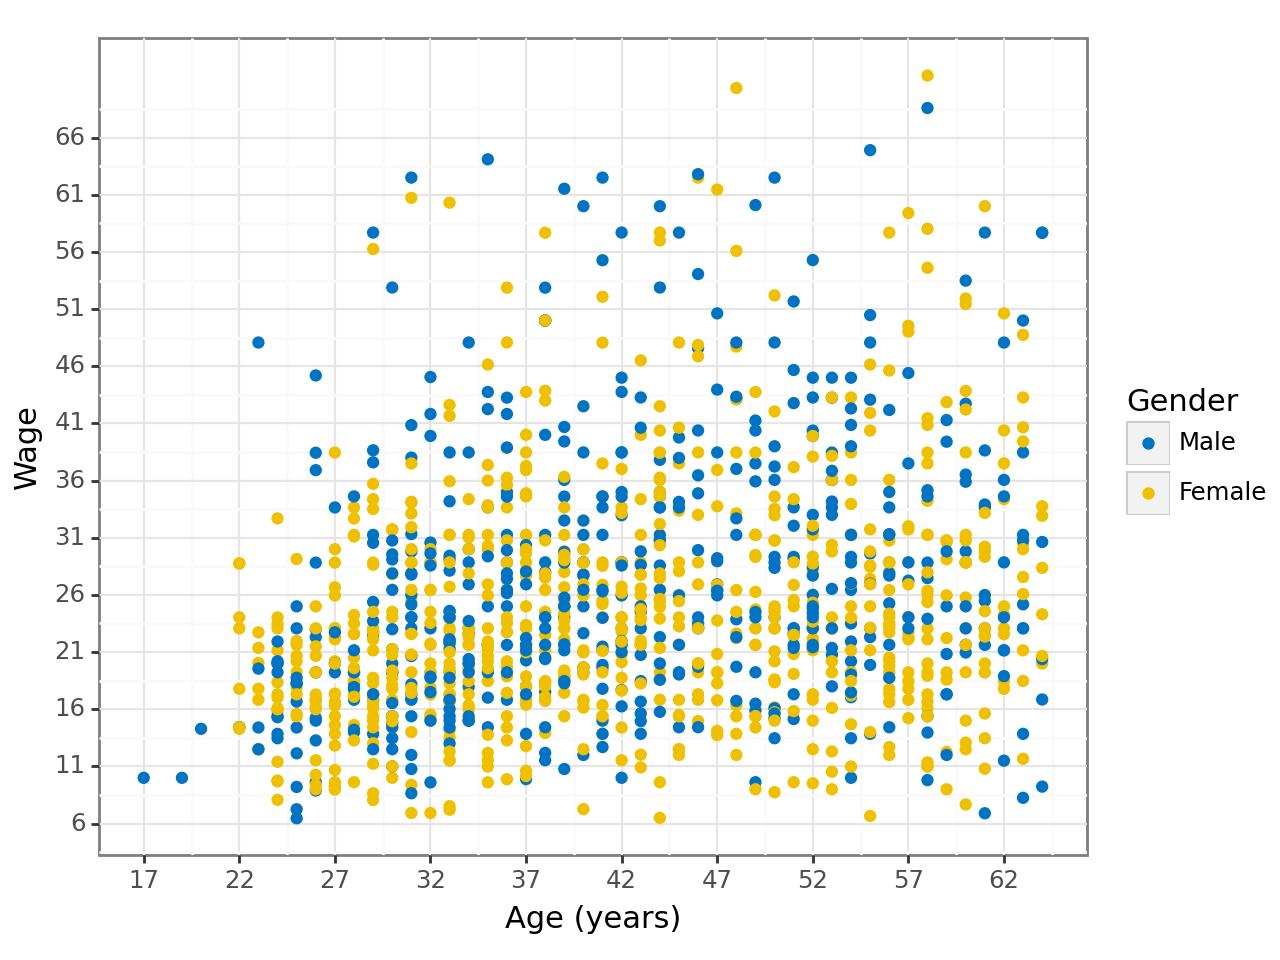

<Figure Size: (640 x 480)>

In [235]:
# Scatter Plot of Wage Distribution by Age and Gender

# Identify and remove the two outliers
q_low = data_occ["w"].quantile(0.01)
q_high = data_occ["w"].quantile(0.99)
data_filtered = data_occ[(data_occ["w"] > q_low) & (data_occ["w"] < q_high)]

# Create the scatter plot
(
    ggplot(data_filtered, aes(x="age", y="w", color="female"))
    + geom_point(alpha=0.8, size=1.5)
    + labs(x="Age (years)", y="Wage", color="Gender")
    + scale_color_manual(values=["#0073C2FF", "#EFC000FF"], labels=["Male", "Female"])
    + scale_x_continuous(
        limits=(data_filtered["age"].min(), data_filtered["age"].max()),
        breaks=range(int(data_filtered["age"].min()), int(data_filtered["age"].max()), 5),
    )
    + scale_y_continuous(
        limits=(data_filtered["w"].min(), data_filtered["w"].max()),
        breaks=range(int(data_filtered["w"].min()), int(data_filtered["w"].max()), 5),
    )
    + theme_bw()
)

In [236]:
data_occ.loc[:, ["age"]].describe()

,age
count,1323.00000
mean,42.35223
std,11.28418
min,17.00000
25%,33.00000
50%,42.00000
75%,52.00000
max,64.00000


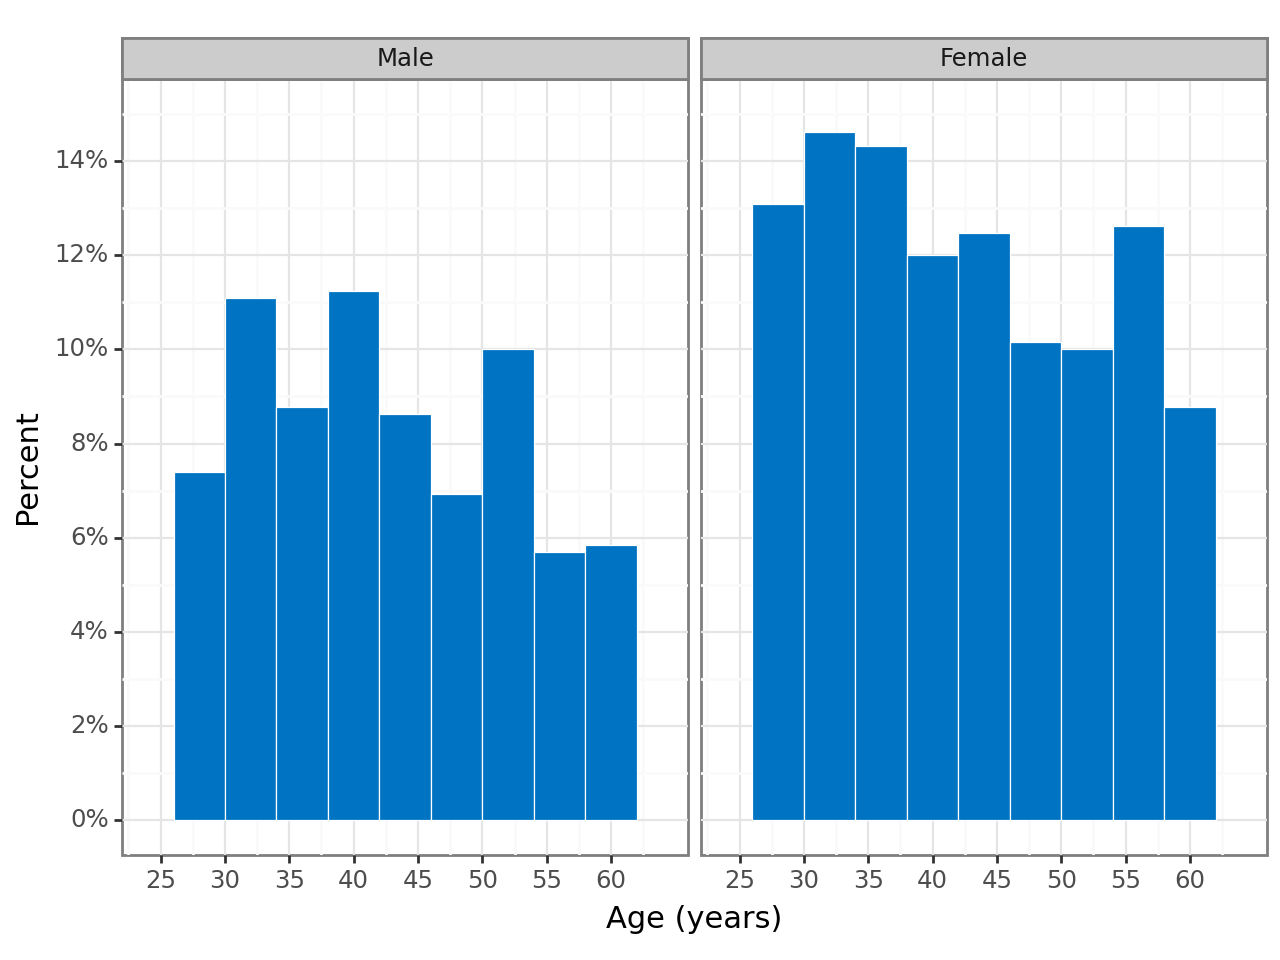

<Figure Size: (640 x 480)>

In [237]:
(
    ggplot(data_occ, aes(x="age", y="2*stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill="#0073C2FF", 
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Age (years)", y="Percent")
    + facet_wrap("~female", labeller=as_labeller({"False": "Male", "True": "Female"}))
    + scale_x_continuous(
        limits=(24, 64),
        breaks=range(25, 65, 5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, 0.02), labels=percent_format()
    )
    + theme_bw()
)

### Linear regressions

In [238]:

model1 = "lnw~female"
reg1 = smf.ols(formula=model1, data=data_occ).fit(cov_type="HC1")
# reg1.summary()

model2 = "lnw~female + age"
reg2 = smf.ols(formula=model2, data=data_occ).fit(cov_type="HC1")
# reg2.summary()

model3 = "lnw~female + age + ed_BA + ed_MA + ed_Profess + ed_Phd"
reg3 = smf.ols(formula=model3, data=data_occ).fit(cov_type="HC1")

model4 = "lnw~female + age + ed_BA + ed_MA + ed_Profess + ed_Phd + native_american"
reg4 = smf.ols(formula=model4, data=data_occ).fit(cov_type="HC1")
# reg4.summary()

model_equations = [model1, model2, model3, model4]


In [239]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["female[T.True]", "age", "ed_BA", "ed_MA", "ed_Profess", "ed_Phd", "native_american", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant", "female[T.True]": "female", "lnw": "log(wage)"})
stargazer


### Cross Validation

In [244]:
n_fold = 4

cv_list = []
for equation in model_equations:
    cv_result = ols_crossvalidator(equation, data_occ, n_fold, average_rmse=False)
    
    # result is a dictionary with expected keys
    if not isinstance(cv_result, dict):
        raise TypeError("ols_crossvalidator did not return a dictionary. Check function output.")

    cv_list.append(cv_result)

# results into DataFrame
cv_df = pd.DataFrame(cv_list).round(3)

In [245]:
# Table (a): RMSE in the full sample
rmse_full_sample_df = (
    cv_df[["RMSE"]]
    .assign(Model=["Model " + str(i + 1) for i in range(len(model_equations))])
    .set_index("Model")
)

print("\nRMSE in Full Sample:")
print(rmse_full_sample_df)



RMSE in Full Sample:
          RMSE
Model         
Model 1  0.476
Model 2  0.464
Model 3  0.452
Model 4  0.452


In [246]:
# Table (b): Cross-validated RMSE
test_rmse_df = pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold " + str(i + 1) for i in range(n_fold)],
).assign(Average=lambda x: x.mean(axis=1)).T.round(2)

print("\nCross-validated RMSE:")
print(test_rmse_df)


Cross-validated RMSE:
         Model 1  Model 2  Model 3  Model 4
Fold 1      0.46     0.46     0.45     0.44
Fold 2      0.51     0.48     0.47     0.47
Fold 3      0.43     0.41     0.41     0.41
Fold 4      0.50     0.51     0.50     0.50
Average     0.48     0.47     0.45     0.45


In [247]:
# Table (c): BIC in the full sample
bic_df = (
    cv_df[["BIC"]]
    .astype(int)
    .assign(Model=["Model " + str(i + 1) for i in range(len(model_equations))])
    .set_index("Model")
)


print("\nBIC in Full Sample:")
print(bic_df)


BIC in Full Sample:
          BIC
Model        
Model 1  1806
Model 2  1746
Model 3  1705
Model 4  1710
